In [100]:
import pandas as pd
import numpy as np
# 1) Load your dataset (adjust the path if needed)
df = pd.read_csv("Amazon Sale Report.csv") # if file is in the same folder as notebook
df.head()

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Category,Size,Courier Status,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,B2B,fulfilled-by,New,PendingS
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,T-shirt,S,On the Way,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,False,Easy Ship,NaN,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,Shirt,3XL,Shipped,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,False,Easy Ship,NaN,NaN
2,2,404-0687676-7273146,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Shirt,XL,Shipped,...,INR,329.00,NAVI MUMBAI,MAHARASHTRA,410210.0,IN,True,NaN,NaN,NaN
3,3,403-9615377-8133951,04-30-22,Cancelled,Merchant,Amazon.in,Standard,Blazzer,L,On the Way,...,INR,753.33,PUDUCHERRY,PUDUCHERRY,605008.0,IN,False,Easy Ship,NaN,NaN
4,4,407-1069790-7240320,04-30-22,Shipped,Amazon,Amazon.in,Expedited,Trousers,3XL,Shipped,...,INR,574.00,CHENNAI,TAMIL NADU,600073.0,IN,False,NaN,NaN,NaN


In [16]:
# 3) — diagnostics
print("Shape:", df.shape)
print("\nColumns:")
for i, c in enumerate(df.columns):
    print(f"{i+1:02d}. {c}")

print("\nDtypes summary:")
print(df.dtypes.value_counts().to_string())

print("\nNull counts (top 30):")
nulls = df.isnull().sum().sort_values(ascending=False)
display(nulls.head(30))

print("\nBasic descriptive stats for numeric cols:")
display(df.select_dtypes(include=np.number).describe().T)


Shape: (128976, 21)

Columns:
01. index
02. Order ID
03. Date
04. Status
05. Fulfilment
06. Sales Channel
07. ship-service-level
08. Category
09. Size
10. Courier Status
11. Qty
12. currency
13. Amount
14. ship-city
15. ship-state
16. ship-postal-code
17. ship-country
18. B2B
19. fulfilled-by
20. New
21. PendingS

Dtypes summary:
object     14
float64     4
int64       2
bool        1

Null counts (top 30):


PendingS              128976
New                   128976
fulfilled-by           89713
currency                7800
Amount                  7800
ship-country              35
ship-postal-code          35
ship-state                35
ship-city                 35
B2B                        0
index                      0
Order ID                   0
Courier Status             0
Size                       0
Category                   0
ship-service-level         0
Sales Channel              0
Fulfilment                 0
Status                     0
Date                       0
Qty                        0
dtype: int64


Basic descriptive stats for numeric cols:


,count,mean,std,min,25%,50%,75%,max
index,128976.0,64486.130427,37232.897832,0.0,32242.75,64486.5,96730.25,128974.0
Qty,128976.0,0.904401,0.313368,0.0,1.00,1.0,1.00,15.0
Amount,121176.0,648.562176,281.185041,0.0,449.00,605.0,788.00,5584.0
ship-postal-code,128941.0,463945.677744,191458.488954,110001.0,382421.00,500033.0,600024.00,989898.0
New,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PendingS,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Cell 4 — normalize column names for easier downstream code
import re

def normalize_col(col):
    col = str(col).strip()
    col = re.sub(r"\s+", "_", col)                # spaces -> underscore
    col = re.sub(r"[^\w_]", "", col)              # remove special chars
    col = re.sub(r"_+", "_", col)                 # collapse underscores
    col = col.strip("_").lower()
    return col

df.columns = [normalize_col(c) for c in df.columns]
print("Normalized columns:")
for i,c in enumerate(df.columns[:50]):
    print(f"{i+1:02d}. {c}")


Normalized columns:
01. index
02. order_id
03. date
04. status
05. fulfilment
06. sales_channel
07. shipservicelevel
08. category
09. size
10. courier_status
11. qty
12. currency
13. amount
14. shipcity
15. shipstate
16. shippostalcode
17. shipcountry
18. b2b
19. fulfilledby
20. new
21. pendings


In [19]:
# Cell 5 — detect likely important columns
cols = df.columns.tolist()
def find_cols(keyword_list):
    return [c for c in cols if any(k in c for k in keyword_list)]

candidates = {
    "order_id": find_cols(["order", "orderid", "order_id", "sale_id", "invoice"]),
    "date": find_cols(["date", "order_date", "sale_date", "purchase_date", "created"]),
    "quantity": find_cols(["qty", "quantity", "qnty", "no_of", "units"]),
    "amount": find_cols(["amount", "price", "total", "order_value", "net_amount", "selling_price", "grand_total"])
}

from pprint import pprint
print("Candidate columns (automatically detected):")
pprint(candidates)


Candidate columns (automatically detected):
{'amount': ['amount'],
 'date': ['date'],
 'order_id': ['order_id'],
 'quantity': ['qty']}


In [20]:
# Cell 6 — convert detected date candidates to datetime
date_cols = candidates["date"]
for c in date_cols:
    try:
        df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=False)  # try MDY first; change if you need DMY
        non_null = df[c].notna().sum()
        print(f"Converted {c} -> datetime; non-null converted: {non_null}/{len(df)}")
    except Exception as e:
        print(f"Could not convert {c}: {e}")

# If no date column was detected, you can manually set it:
# df['order_date'] = pd.to_datetime(df['Order Date'], errors='coerce', dayfirst=True)


Converted date -> datetime; non-null converted: 128976/128976


C:\Users\Hp\AppData\Local\Temp\ipykernel_5524\2262228992.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[c] = pd.to_datetime(df[c], errors='coerce', dayfirst=False)  # try MDY first; change if you need DMY


In [21]:
# Cell 7 — detect and coerce numeric columns (quantity & amount heuristics)
def clean_numeric(col):
    # remove currency symbols, commas, spaces, parentheses; convert to float
    return pd.to_numeric(df[col].astype(str).str.replace(r"[^\d.\-]", "", regex=True), errors='coerce')

# Quantity
qty_cols = candidates["quantity"]
for c in qty_cols:
    df[c] = clean_numeric(c)
    print(f"{c}: converted nums — non-null count: {df[c].notna().sum()}")

# Amount
amt_cols = candidates["amount"]
for c in amt_cols:
    df[c] = clean_numeric(c)
    print(f"{c}: converted nums — non-null count: {df[c].notna().sum()}")


qty: converted nums — non-null count: 128976
amount: converted nums — non-null count: 121176


In [22]:
# Cell 8 — duplicates
print("Total exact duplicate rows:", df.duplicated().sum())

# If you have an order id use it; else drop exact duplicates
order_id_cols = candidates["order_id"]
if order_id_cols:
    oid = order_id_cols[0]
    print("Using order id column to find duplicate orders:", oid)
    dup_by_oid = df.duplicated(subset=[oid]).sum()
    print(f"Duplicates by {oid}: {dup_by_oid}")
    # Optionally drop exact duplicate rows:
    # df = df.drop_duplicates()
else:
    print("No obvious order_id column found. Dropping exact duplicate rows.")
    df = df.drop_duplicates()

# Missing-value quick decision (example rules — adapt to your business needs)
missing_summary = df.isnull().sum().sort_values(ascending=False)
display(missing_summary.head(30))

# Example imputation template:
# - If qty missing -> assume 1? or drop those rows (business decision)
# - If amount missing -> cannot compute revenue; review those rows
# Below is a conservative approach: show rows with missing in critical cols
critical_cols = []
if qty_cols: critical_cols += qty_cols
if amt_cols: critical_cols += amt_cols
critical_cols = list(dict.fromkeys(critical_cols))  # unique preserve order

if critical_cols:
    print("\nRows with missing critical columns (show up to 10):")
    display(df[df[critical_cols].isnull().any(axis=1)].head(10))
else:
    print("\nNo auto-detected critical cols for missing-value check; identify manually if needed.")


Total exact duplicate rows: 168
Using order id column to find duplicate orders: order_id
Duplicates by order_id: 8747


pendings            128976
new                 128976
fulfilledby          89713
currency              7800
amount                7800
shipcountry             35
shippostalcode          35
shipstate               35
shipcity                35
b2b                      0
index                    0
order_id                 0
courier_status           0
size                     0
category                 0
shipservicelevel         0
sales_channel            0
fulfilment               0
status                   0
date                     0
qty                      0
dtype: int64


Rows with missing critical columns (show up to 10):


,index,order_id,date,status,fulfilment,sales_channel,shipservicelevel,category,size,courier_status,...,currency,amount,shipcity,shipstate,shippostalcode,shipcountry,b2b,fulfilledby,new,pendings
8,8,407-5443024-5233168,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,T-shirt,3XL,Cancelled,...,NaN,NaN,HYDERABAD,TELANGANA,500008.0,IN,False,NaN,NaN,NaN
29,29,404-5933402-8801952,2022-04-30,Cancelled,Merchant,Amazon.in,Standard,Shirt,3XL,On the Way,...,NaN,NaN,GUWAHATI,ASSAM,781003.0,IN,False,Easy Ship,NaN,NaN
65,65,171-4137548-0481151,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,Shirt,XXL,Cancelled,...,NaN,NaN,Dahod,Gujarat,389151.0,IN,False,NaN,NaN,NaN
84,84,403-9950518-0349133,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,Shirt,M,Cancelled,...,NaN,NaN,HYDERABAD,TELANGANA,500072.0,IN,False,NaN,NaN,NaN
95,95,405-9112089-3379536,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,Shirt,L,Cancelled,...,NaN,NaN,PUNE,MAHARASHTRA,411046.0,IN,False,NaN,NaN,NaN
101,101,402-7841951-1872363,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,T-shirt,S,Cancelled,...,NaN,NaN,NEW DELHI,DELHI,110036.0,IN,False,NaN,NaN,NaN
132,132,171-0293372-4913973,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,T-shirt,3XL,Cancelled,...,NaN,NaN,KOLAR,KARNATAKA,563101.0,IN,False,NaN,NaN,NaN
139,139,403-6442534-2769112,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,Trousers,3XL,Cancelled,...,NaN,NaN,AZAMGARH,UTTAR PRADESH,276302.0,IN,False,NaN,NaN,NaN
155,155,402-8078642-8565124,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,Shirt,XL,Cancelled,...,NaN,NaN,Puri-2,ODISHA,752002.0,IN,False,NaN,NaN,NaN
165,165,406-0218328-1773963,2022-04-30,Cancelled,Amazon,Amazon.in,Expedited,Shirt,6XL,Cancelled,...,NaN,NaN,WALAJAPET,TAMIL NADU,632513.0,IN,False,NaN,NaN,NaN


In [23]:
# Save cleaned data in the same folder
df.to_csv("amazon_sales_cleaned.csv", index=False)


In [63]:
#️⃣ Create Month, Year, Weekday from Order Date

# Replace 'Order Date' with your actual date column name
if "date" in df.columns:
    df["order_year"] = df["date"].dt.year
    df["order_month"] = df["date"].dt.month
    df["order_day"] = df["date"].dt.day
    df["order_weekday"] = df["date"].dt.day_name()  # e.g., Monday, Tuesday
    print("Added order_year, order_month, order_day, order_weekday columns.")
# 2) Create revenue column
df['revenue'] = df['qty'] * df['amount']   # <-- do it here

# 3) Optional: high value orders
df["high_value_order"] = df["revenue"] > df["revenue"].quantile(0.9)

Added order_year, order_month, order_day, order_weekday columns.


In [26]:
#️⃣ Categorize Products

if "Category" in df.columns:
    df["category_clean"] = df["Category"].str.strip().str.title()
    print("Cleaned category names in category_clean column.")


In [28]:
df.to_csv("amazon_sales_featured.csv", index=False)
print("Saved feature-engineered dataset as amazon_sales_featured.csv")


Saved feature-engineered dataset as amazon_sales_featured.csv


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd

sns.set(style="whitegrid")

# Make folder to save plots
PLOT_DIR = "plots"
os.makedirs(PLOT_DIR, exist_ok=True)

# Standardize column names: lowercase & remove spaces
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

# Create revenue if it doesn't exist
if "revenue" not in df.columns and "qty" in df.columns and "amount" in df.columns:
    df["revenue"] = df["qty"] * df["amount"]

# Dynamically detect numeric columns for distributions
numeric_cols = [c for c in ["qty","amount","revenue"] if c in df.columns]


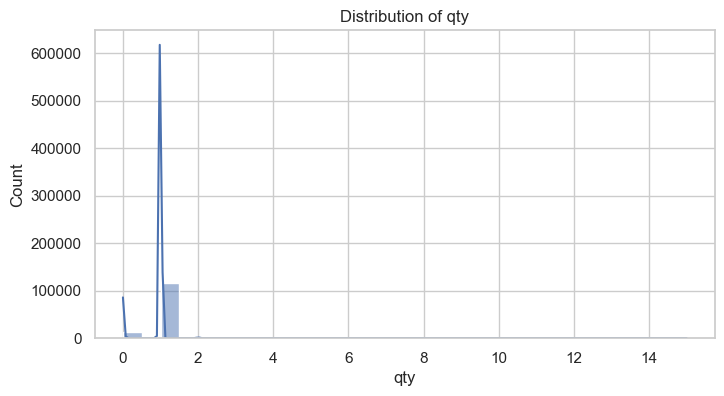

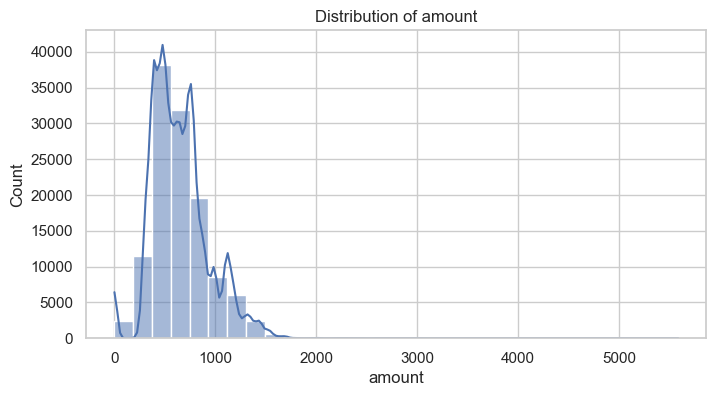

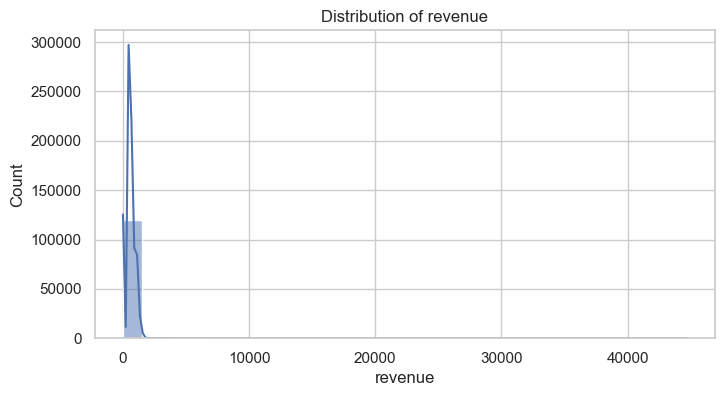

In [30]:
# 1️⃣ Distribution plots
for col in numeric_cols:
    plt.figure(figsize=(8,4))
    sns.histplot(df[col].dropna(), bins=30, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.savefig(f"{PLOT_DIR}/distribution_{col}.png", bbox_inches='tight')
    plt.show()

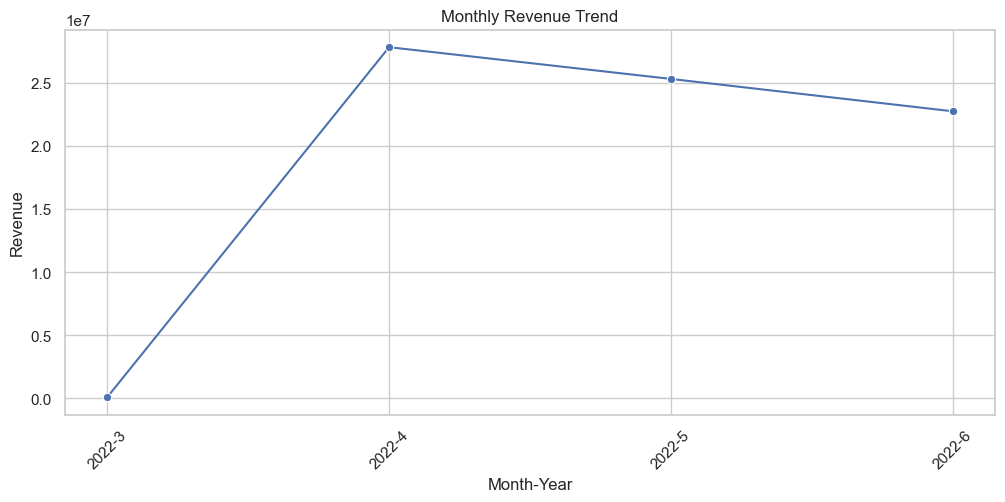

In [66]:
# 2️⃣ Monthly Revenue Trend
if all(x in df.columns for x in ["order_year","order_month","revenue"]):
    monthly_sales = df.groupby(["order_year","order_month"])["revenue"].sum().reset_index()
    monthly_sales["month_year"] = monthly_sales["order_year"].astype(str) + "-" + monthly_sales["order_month"].astype(str)
    
    plt.figure(figsize=(12,5))
    sns.lineplot(x="month_year", y="revenue", data=monthly_sales, marker="o")
    plt.xticks(rotation=45)
    plt.title("Monthly Revenue Trend")
    plt.ylabel("Revenue")
    plt.xlabel("Month-Year")
    plt.savefig(f"{PLOT_DIR}/monthly_revenue_trend.png", bbox_inches='tight')
    plt.show()

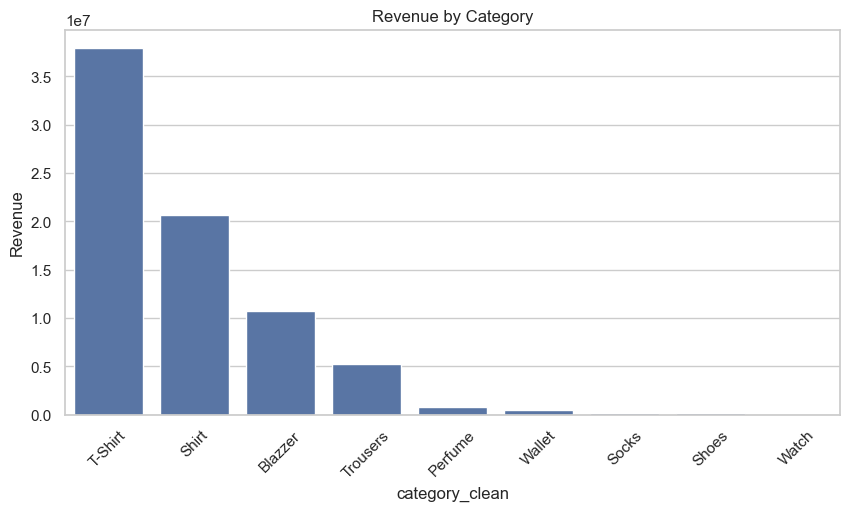

In [68]:
# 3️⃣ Revenue by Category
if "category" in df.columns:
    df["category_clean"] = df["category"].str.strip().str.title()

    cat_sales = df.groupby("category_clean")["revenue"].sum().sort_values(ascending=False)
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=cat_sales.index, y=cat_sales.values)
    plt.xticks(rotation=45)
    plt.title("Revenue by Category")
    plt.ylabel("Revenue")
    plt.savefig(f"{PLOT_DIR}/revenue_by_category.png", bbox_inches='tight')
    plt.show()

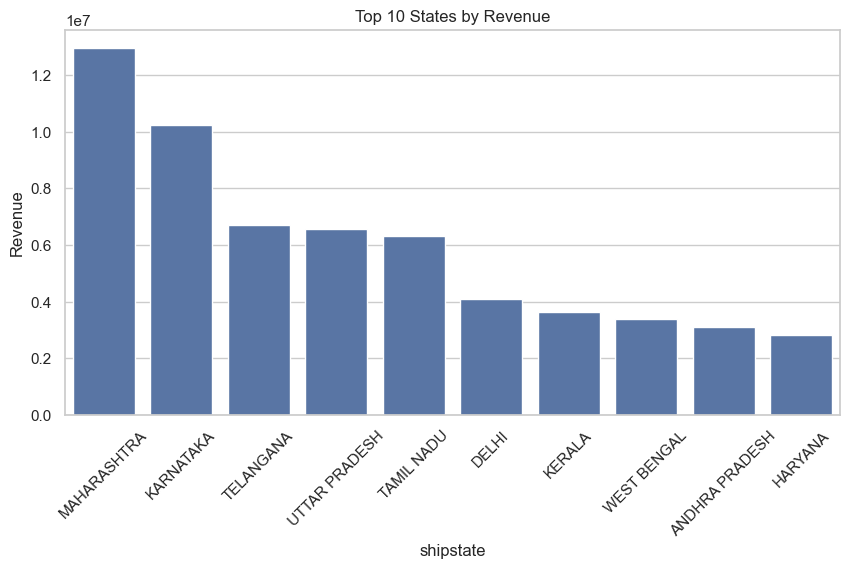

In [76]:
if "shipstate" in df.columns and "revenue" in df.columns:
    state_sales = df.groupby("shipstate")["revenue"].sum().sort_values(ascending=False).head(10)
    
    plt.figure(figsize=(10,5))
    sns.barplot(x=state_sales.index, y=state_sales.values)
    plt.xticks(rotation=45)
    plt.title("Top 10 States by Revenue")
    plt.ylabel("Revenue")
    plt.savefig(f"{PLOT_DIR}/top10_states_revenue.png", bbox_inches='tight')
    plt.show()


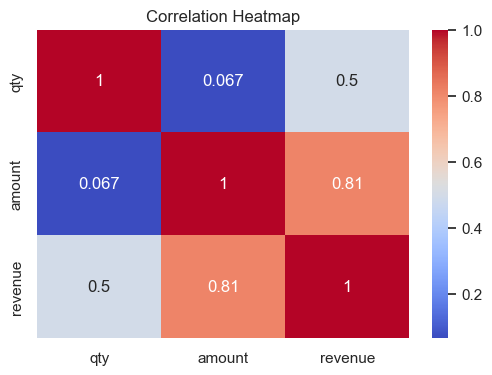

In [78]:
# 5️⃣ Correlation Heatmap
numeric_cols_existing = [c for c in ["qty","amount","revenue"] if c in df.columns]
if numeric_cols_existing:
    plt.figure(figsize=(6,4))
    sns.heatmap(df[numeric_cols_existing].dropna().corr(), annot=True, cmap="coolwarm")
    plt.title("Correlation Heatmap")
    plt.savefig(f"{PLOT_DIR}/correlation_heatmap.png", bbox_inches='tight')
    plt.show()


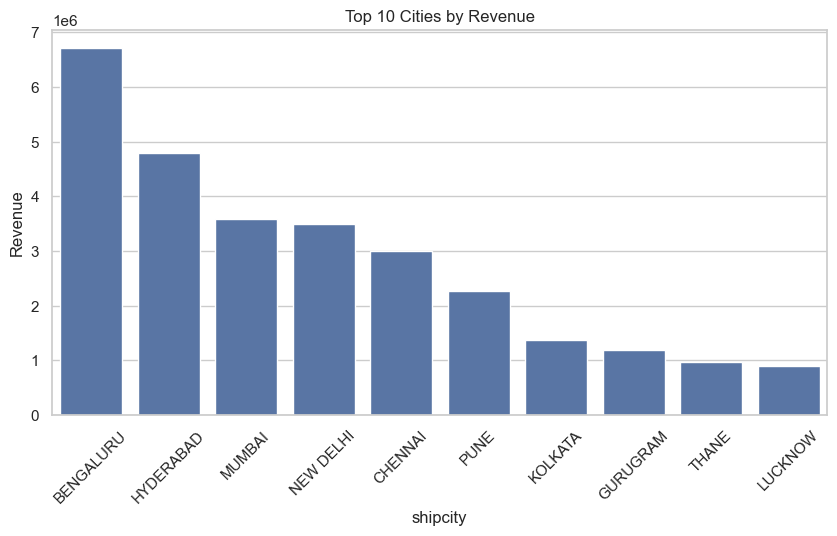

In [80]:
# --- Revenue by Ship City (Top 10) ---
if "shipcity" in df.columns and "revenue" in df.columns:
    city_sales = df.groupby("shipcity")["revenue"].sum().sort_values(ascending=False).head(10)
    plt.figure(figsize=(10,5))
    sns.barplot(x=city_sales.index, y=city_sales.values)
    plt.xticks(rotation=45)
    plt.title("Top 10 Cities by Revenue")
    plt.ylabel("Revenue")
    plt.savefig(f"{PLOT_DIR}/top10_cities_revenue.png", bbox_inches='tight')
    plt.show()

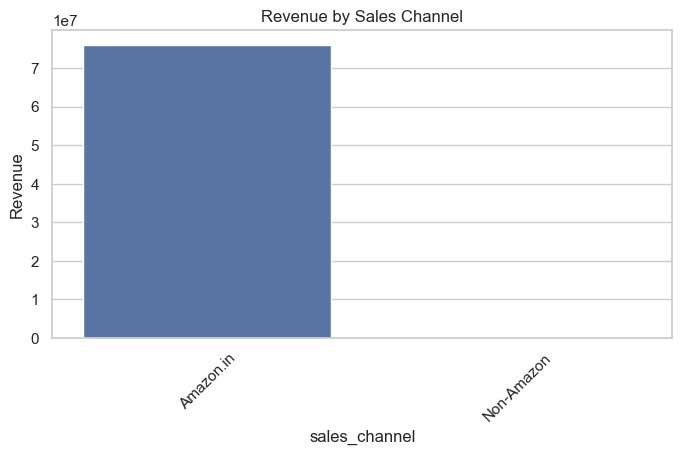

In [82]:
# --- Revenue by Sales Channel ---
if "sales_channel" in df.columns and "revenue" in df.columns:
    channel_sales = df.groupby("sales_channel")["revenue"].sum().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=channel_sales.index, y=channel_sales.values)
    plt.xticks(rotation=45)
    plt.title("Revenue by Sales Channel")
    plt.ylabel("Revenue")
    plt.savefig(f"{PLOT_DIR}/revenue_by_channel.png", bbox_inches='tight')
    plt.show()

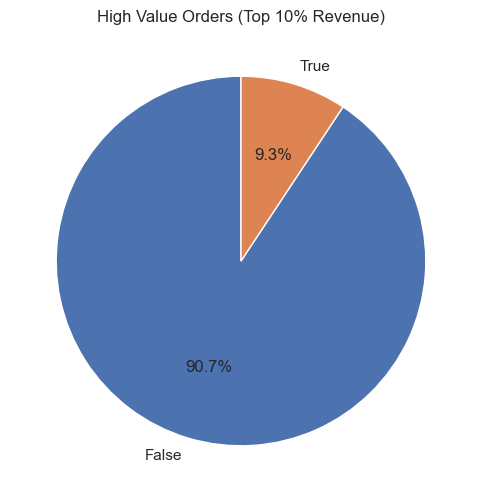

In [84]:
# --- High-Value Orders Analysis ---
if "high_value_order" in df.columns:
    high_value_counts = df["high_value_order"].value_counts()
    plt.figure(figsize=(6,6))
    plt.pie(high_value_counts, labels=high_value_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title("High Value Orders (Top 10% Revenue)")
    plt.savefig(f"{PLOT_DIR}/high_value_orders.png", bbox_inches='tight')
    plt.show()

C:\Users\Hp\AppData\Local\Temp\ipykernel_5524\2337717658.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="status", y="count", data=status_counts, palette="viridis")


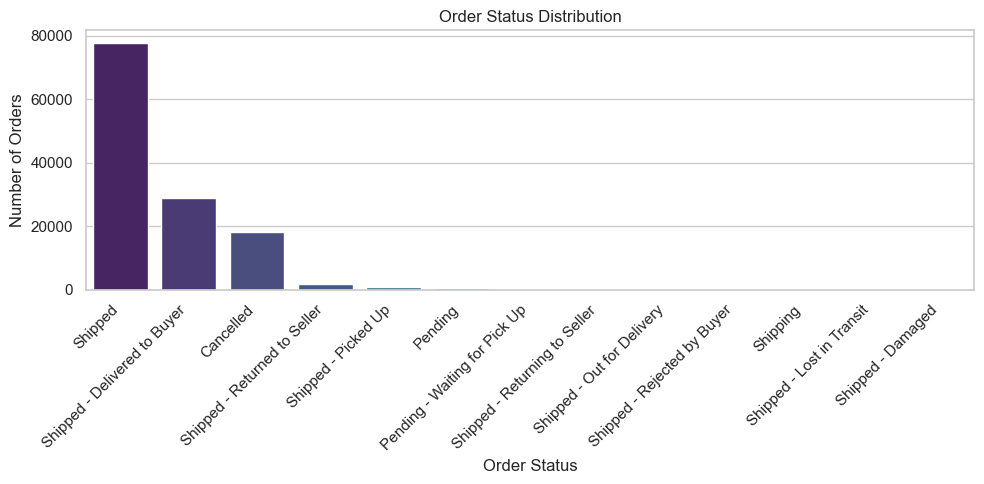

In [92]:
# --- Order Status Distribution (Clean Bar Chart) ---
if "status" in df.columns:
    status_counts = df["status"].value_counts().reset_index()
    status_counts.columns = ["status", "count"]
    
    plt.figure(figsize=(10,5))
    sns.barplot(x="status", y="count", data=status_counts, palette="viridis")
    plt.xticks(rotation=45, ha='right')
    plt.title("Order Status Distribution")
    plt.ylabel("Number of Orders")
    plt.xlabel("Order Status")
    plt.tight_layout()
    plt.savefig(f"{PLOT_DIR}/order_status_distribution_bar.png", bbox_inches='tight')
    plt.show()


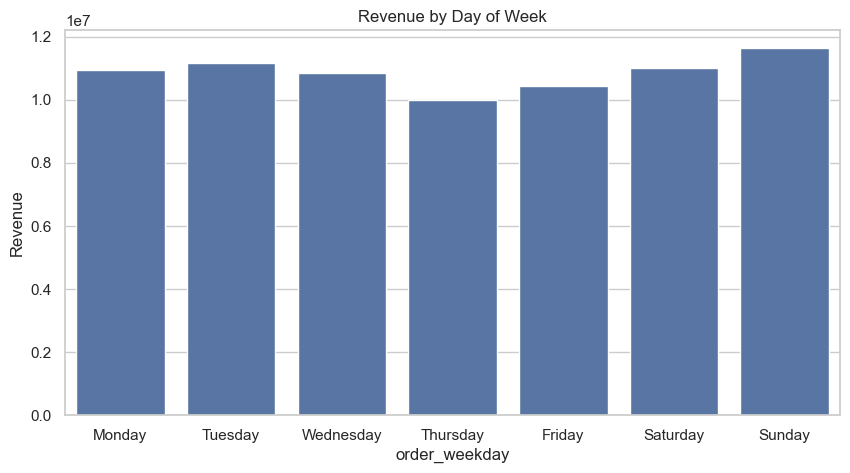

In [88]:
# ---  Revenue by Day of Week ---
if "order_weekday" in df.columns and "revenue" in df.columns:
    weekday_sales = df.groupby("order_weekday")["revenue"].sum().reindex(
        ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
    )
    plt.figure(figsize=(10,5))
    sns.barplot(x=weekday_sales.index, y=weekday_sales.values)
    plt.title("Revenue by Day of Week")
    plt.ylabel("Revenue")
    plt.savefig(f"{PLOT_DIR}/revenue_by_weekday.png", bbox_inches='tight')
    plt.show()

In [94]:
# 📊 KPI & Insights Summary

# --- Core KPIs ---
total_orders = df['order_id'].nunique()
total_revenue = df['revenue'].sum()
avg_order_value = total_revenue / total_orders

top_category = df.groupby('category_clean')['revenue'].sum().idxmax()
top_state = df.groupby('shipstate')['revenue'].sum().idxmax()
top_city = df.groupby('shipcity')['revenue'].sum().idxmax()

high_value_orders_pct = (df['high_value_order'].sum() / len(df)) * 100

# --- Order Status Breakdown ---
status_dist = df['status'].value_counts(normalize=True) * 100

# --- Revenue by Weekday ---
weekday_revenue = df.groupby('order_weekday')['revenue'].sum().sort_values(ascending=False)
busiest_day = weekday_revenue.idxmax()

# --- Print Insights ---
print("===== Amazon Sales Report Insights =====\n")
print(f"📦 Total Orders: {total_orders}")
print(f"💰 Total Revenue: ₹{total_revenue:,.2f}")
print(f"🛒 Average Order Value (AOV): ₹{avg_order_value:,.2f}\n")

print(f"🏆 Top Category by Revenue: {top_category}")
print(f"🌍 Top State by Revenue: {top_state}")
print(f"🏙️ Top City by Revenue: {top_city}\n")

print(f"🔥 High Value Orders: {high_value_orders_pct:.2f}% of all orders\n")

print("🚚 Order Status Distribution:")
print(status_dist.to_string(), "\n")

print(f"📅 Busiest Day of the Week: {busiest_day}")
print("\n========================================")


===== Amazon Sales Report Insights =====

📦 Total Orders: 120229
💰 Total Revenue: ₹76,031,267.00
🛒 Average Order Value (AOV): ₹632.39

🏆 Top Category by Revenue: T-Shirt
🌍 Top State by Revenue: MAHARASHTRA
🏙️ Top City by Revenue: BENGALURU

🔥 High Value Orders: 9.31% of all orders

🚚 Order Status Distribution:
status
Shipped                          60.332930
Shipped - Delivered to Buyer     22.295621
Cancelled                        14.215048
Shipped - Returned to Seller      1.515011
Shipped - Picked Up               0.754404
Pending                           0.510172
Pending - Waiting for Pick Up     0.217870
Shipped - Returning to Seller     0.112424
Shipped - Out for Delivery        0.027137
Shipped - Rejected by Buyer       0.008529
Shipping                          0.006203
Shipped - Lost in Transit         0.003877
Shipped - Damaged                 0.000775 

📅 Busiest Day of the Week: Sunday

